In [1]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

# Task 1. House price prediction using 311 data

### Can 311 complaining profile of urban neighborhoods enhance real-estate price prediction?

[Zhu, E., & Sobolevsky, S. (2018). House Price Modeling with Digital Census. arXiv preprint arXiv:1809.03834.]

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample of more than 14000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complaints happening in the area.

In [2]:
folder=''

In [3]:
REsample=pd.read_csv(folder+'data/NYChome_sales2012.csv',index_col=0)

In [4]:
len(REsample)

14611

In [5]:
REsample.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
204018,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,11413,0,3560,1473,1940,0,2012-01-01
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217598,2,BAYCHESTER,4707,70,NaN,A5,1134 EAST 213 STREET,10469,0,2320,1813,1950,335700,2012-05-17
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,1998,1945,0,2012-12-20


In [6]:
REsample.columns

Index(['borough', 'neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'zip_code', 'commmercial_units',
       'land_sq_feet', 'gross_sq_feet', 'year_built', 'sale_price',
       'sale_date'],
      dtype='object')

In [26]:
REsample = REsample[REsample.sale_price>0]

In [27]:
#how many houses do we have per each borough?
np.bincount(REsample.borough)

array([   0,  125,  623, 1693, 4666, 2101])

In [28]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(REsample))
REsample1=REsample.loc[splitind<=0.4]
REsample2=REsample.loc[(splitind>0.4)&(splitind<0.7)]
REsample3=REsample.loc[(splitind>=0.7)]

In [29]:
len(REsample1) #loosing around 50 records within sparse zip codes

3660

In [30]:
len(REsample2)

2761

In [31]:
len(REsample3)

2787

In [32]:
# now load and curate 311 data which we're going to use in order to characterize the location

In [33]:
data311 = pd.read_csv( folder+'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [34]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [35]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [36]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [37]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [38]:
list_311=list(data311.columns)

In [39]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [40]:
len(data311) #only 179 zip codes with reliable data left

179

In [41]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


#### Q1. Run linear regression 'sale_price ~ gross_sq_feet+land_sq_feet+year_built' over the training data

In [42]:
lm = smf.ols('sale_price ~ gross_sq_feet+land_sq_feet+year_built', data=REsample1).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     564.0
Date:                Sat, 09 Nov 2019   Prob (F-statistic):          3.13e-301
Time:                        15:40:14   Log-Likelihood:                -55672.
No. Observations:                3660   AIC:                         1.114e+05
Df Residuals:                    3656   BIC:                         1.114e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.256e+07   1.21e+06     10.395      0.000    1.02e+07    1.49e+07
gross_sq_feet   743.4321     18.595     39.979      0.000     706.974     779.891
land_sq_feet    -52.0978      5.883     -8.856      0.000     -63.632     -40.564
year_built    -6742.0815    623.614    -10.811      0.000   -7964.747   -5519.416
==============================================================================
Omnibus:                     5510.098   Durbin-Watson:                   1.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3746242.831
Skew:                           9.011   Prob(JB):                         0.00
Kurtosis:                     158.694   Cond. No.                     3.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Q2. Add 311 data corresponding to the zip code of the house location to REsample1,2,3 
in order to characterize the house's neighborhood by merging the dataframes REsample1,2,3 with data311 by zip code. Name merged dataframes REsample1_311, REsample2_311, REsample3_311 
rename 311 columns to F1,F2,... for easier formulae engineering
but keep the original names as a dictionary {'F1':'APPLIANCE', ...}

In [43]:
column_dict = dict(zip(['F'+str(i+1) for i in range(len(data311.columns.values))],data311.columns.values))
column_dict

{'F1': 'APPLIANCE',
 'F2': 'Adopt-A-Basket',
 'F3': 'Air Quality',
 'F4': 'Animal Abuse',
 'F5': 'Animal Facility - No Permit',
 'F6': 'Animal in a Park',
 'F7': 'Asbestos',
 'F8': 'BEST/Site Safety',
 'F9': 'Beach/Pool/Sauna Complaint',
 'F10': 'Bike Rack Condition',
 'F11': 'Bike/Roller/Skate Chronic',
 'F12': 'Blocked Driveway',
 'F13': 'Boilers',
 'F14': 'Bottled Water',
 'F15': 'Bridge Condition',
 'F16': 'Broken Muni Meter',
 'F17': 'Broken Parking Meter',
 'F18': 'Building Condition',
 'F19': 'Building/Use',
 'F20': 'Bus Stop Shelter Placement',
 'F21': 'CONSTRUCTION',
 'F22': 'Calorie Labeling',
 'F23': 'City Vehicle Placard Complaint',
 'F24': 'Collection Truck Noise',
 'F25': 'Construction',
 'F26': 'Consumer Complaint',
 'F27': 'Cranes and Derricks',
 'F28': 'Curb Condition',
 'F29': 'DOF Parking - Tax Exemption',
 'F30': 'DPR Internal',
 'F31': 'Damaged Tree',
 'F32': 'Dead Tree',
 'F33': 'Derelict Bicycle',
 'F34': 'Derelict Vehicle',
 'F35': 'Derelict Vehicles',
 'F36': '

In [45]:
data311_copy = data311.copy()
data311_copy.columns = ['F'+str(i+1) for i in range(len(data311.columns.values))]

In [46]:
# merge house data with 311 data
REsample1_311 = pd.merge(REsample1, data311_copy, how='inner', left_on='zip_code', right_index=True)
REsample2_311 = pd.merge(REsample2, data311_copy, how='inner', left_on='zip_code', right_index=True)
REsample3_311 = pd.merge(REsample3, data311_copy, how='inner', left_on='zip_code', right_index=True)
REsample1_311.shape, REsample2_311.shape, REsample3_311.shape


((3598, 176), (2727, 176), (2745, 176))

#### Q3. Run the linear model with 311
Train the model over the training sample REsample1_311 and test over the test sample REsample3_311,
report training and test R2

In [49]:
lm_311 = smf.ols('sale_price~gross_sq_feet+land_sq_feet+year_built+'+'+'.join(['F'+str(i+1) for i in range(len(data311.columns.values))]), data=REsample1_311).fit()
lm_311.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     64.95
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:44:22   Log-Likelihood:                -53105.
No. Observations:                3598   AIC:                         1.065e+05
Df Residuals:                    3456   BIC:                         1.074e+05
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.288e+07   4.38e+07      1.436      0.151    -2.3e+07    1.49e+08
gross_sq_feet   227.8958     15.522     14.682      0.000     197.462     258.330
land_sq_feet     17.8525      4.501      3.966      0.000       9.027      26.678
year_built     -197.6351    575.301     -0.344      0.731   -1325.599     930.329
F1            -2.061e+08   1.45e+08     -1.421      0.155   -4.91e+08    7.83e+07
F2            -5.152e+09   1.66e+09     -3.105      0.002   -8.41e+09    -1.9e+09
F3            -1.351e+07   5.99e+07     -0.225      0.822   -1.31e+08    1.04e+08
F4             4.406e+07    1.5e+08      0.294      0.769    -2.5e+08    3.38e+08
F5             2.095e+08   1.46e+09      0.143      0.886   -2.66e+09    3.08e+09
F6             2.454e+07   1.38e+08      0.178      0.859   -2.46e+08    2.95e+08
F7              3.31e+08   2.02e+08      1.642      0.101   -6.43e+07    7.26e+08
F8             1.104e+08   2.69e+08      0.410      0.682   -4.18e+08    6.38e+08
F9            -6.668e+08   4.91e+08     -1.358      0.174   -1.63e+09    2.96e+08
F10            1.124e+09   1.03e+09      1.092      0.275   -8.94e+08    3.14e+09
F11           -6.443e+08   6.36e+08     -1.013      0.311   -1.89e+09    6.02e+08
F12           -8.469e+07   4.48e+07     -1.891      0.059   -1.72e+08    3.12e+06
F13           -3.044e+08   2.69e+08     -1.130      0.259   -8.33e+08    2.24e+08
F14           -7.489e+08   9.45e+08     -0.792      0.428    -2.6e+09     1.1e+09
F15            -1.62e+09   8.49e+08     -1.909      0.056   -3.28e+09    4.41e+07
F16           -6.972e+07    4.5e+07     -1.548      0.122   -1.58e+08    1.86e+07
F17             5.16e+08   5.61e+08      0.920      0.358   -5.84e+08    1.62e+09
F18           -1.475e-05      0.000     -0.079      0.937      -0.000       0.000
F19           -2.614e+07   5.32e+07     -0.491      0.623    -1.3e+08    7.81e+07
F20            9.733e+07   2.26e+08      0.431      0.666   -3.45e+08     5.4e+08
F21           -2.893e+08   2.31e+08     -1.254      0.210   -7.42e+08    1.63e+08
F22           -1.251e+08   1.03e+09     -0.121      0.903   -2.14e+09    1.89e+09
F23            1.439e+09      5e+08      2.879      0.004    4.59e+08    2.42e+09
F24            9.009e+08   8.03e+08      1.122      0.262   -6.74e+08    2.48e+09
F25            -8.93e+07   5.03e+07     -1.776      0.076   -1.88e+08    9.27e+06
F26           -6.702e+07   4.34e+07     -1.543      0.123   -1.52e+08    1.82e+07
F27           -1.157e+09   4.09e+08     -2.833      0.005   -1.96e+09   -3.56e+08
F28           -2.942e+07   1.31e+08     -0.224      0.822   -2.86e+08    2.28e+08
F29            5.138e+08   3.91e+08      1.314      0.189   -2.53e+08    1.28e+09
F30            1.611e+09   5.31e+08      3.035      0.002     5.7e+08    2.65e+09
F31           -8.933e+07   4.77e+07     -1.875   

In [51]:
print('training R2',lm_311.rsquared)
print('test R2',r2_score(REsample3_311['sale_price'] ,lm_311.predict(REsample3_311[['gross_sq_feet','land_sq_feet','year_built']+['F'+str(i+1) for i in range(len(data311.columns.values))]])))


training R2 0.7260285964527089
test R2 0.5350490932794765


#### Q4. Apply regularization
Train Ridge and Lasso over REsample1_311 with an arbitrary default parameter $\alpha=1$.
Then evaluate their out-of-sample performance over REsample3_311
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [52]:
# Scaling
X_train = REsample1_311[['gross_sq_feet','land_sq_feet','year_built']+['F'+str(i+1) for i in range(len(data311.columns.values))]]
y_train = REsample1_311['sale_price']
X_validation = REsample2_311[['gross_sq_feet','land_sq_feet','year_built']+['F'+str(i+1) for i in range(len(data311.columns.values))]]
y_validation = REsample2_311['sale_price']
X_test = REsample3_311[['gross_sq_feet','land_sq_feet','year_built']+['F'+str(i+1) for i in range(len(data311.columns.values))]]
y_test = REsample3_311['sale_price']

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_validation_norm = scaler.transform(X_validation)
X_test_norm = scaler.transform(X_test)

In [53]:
# Ridge
ridge = linear_model.Ridge(alpha=1.0).fit(X_train_norm, y_train)
print('Training R_2:', ridge.score(X_train_norm, y_train))
print('Test R_2:', r2_score(y_test, ridge.predict(X_test_norm)))

Training R_2: 0.7259187220515212
Test R_2: 0.5352764717073895


In [54]:
# Lasso
lasso = linear_model.Lasso(alpha=1.0).fit(X_train_norm, y_train)
print('Training R_2:', lasso.score(X_train_norm, y_train))
print('Test R_2:', r2_score(y_test, lasso.predict(X_test_norm)))

Training R_2: 0.7258709585661056
Test R_2: 0.4963382618644676


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 690164517186142.4, tolerance: 508029298377.8664
  positive)


#### Q5. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set

In [55]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

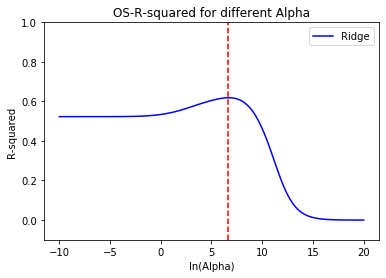

Optimal alpha for Ridge=785.7719942274182, best OS R_2=0.6187552288373341


In [56]:
# Optimize Ridge
alphas = np.exp(np.linspace(-10,20, num=100))
[alpha_optimal, best_R2, best_coefs] = Regularization_fit_alpha(1,X_train_norm,y_train,X_validation_norm,y_validation,alphas,Graph=True, logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))


In [59]:
ridge_optimal = linear_model.Ridge(alpha=alpha_optimal).fit(X_train_norm, y_train)
print('R_2 on training set:', r2_score(y_train, ridge_optimal.predict(X_train_norm)))
print('R_2 on validation set:', r2_score(y_validation, ridge_optimal.predict(X_validation_norm)))
print('R_2 on test set:', r2_score(y_test, ridge_optimal.predict(X_test_norm)))

R_2 on training set: 0.7037552452427795
R_2 on validation set: 0.6187552288373341
R_2 on test set: 0.5716960869372967


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 696326830808591.9, tolerance: 508029298377.8664
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 696326732146714.1, tolerance: 508029298377.8664
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 696326598562900.8, tolerance: 508029298377.8664
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 696326417696

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691780006328415.6, tolerance: 508029298377.8664
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 690164517186142.4, tolerance: 508029298377.8664
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687972111596107.8, tolerance: 508029298377.8664
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 684994396153

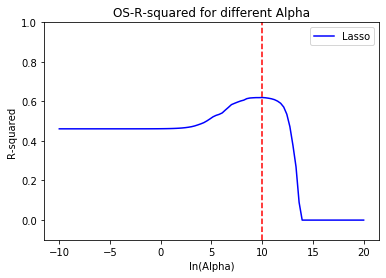

Optimal alpha for Lasso=22026.465794806718, best OS R_2=0.6198586618263923


In [60]:
# Optimize Lasso
[alpha_optimal, best_R2, best_coefs] = Regularization_fit_alpha(2,X_train_norm,y_train,X_validation_norm,y_validation,alphas,Graph=True, logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [61]:
lasso_optimal = linear_model.Lasso(alpha=alpha_optimal).fit(X_train_norm, y_train)
print('R_2 on training set:', r2_score(y_train, lasso_optimal.predict(X_train_norm)))
print('R_2 on validation set:', r2_score(y_validation, lasso_optimal.predict(X_validation_norm)))
print('R_2 on test set:', r2_score(y_test, lasso_optimal.predict(X_test_norm)))

R_2 on training set: 0.6956142582719754
R_2 on validation set: 0.6198586618263923
R_2 on test set: 0.598637475117919


#### Task 2. Model Mean income of the zip code population using 311 profile of the neighborhood

In [62]:
#load the data
dataIncome=pd.read_csv(folder+"data/MeanZip.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.head()

,Median,Mean,Pop
Zip,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


In [63]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(dataIncome))
dataIncome1=dataIncome.loc[splitind<=0.4]
dataIncome2=dataIncome.loc[(splitind>0.4)&(splitind<0.7)]
dataIncome3=dataIncome.loc[(splitind>=0.7)]

In [64]:
dataIncome1.shape, dataIncome2.shape, dataIncome3.shape

((13128, 3), (9827, 3), (9672, 3))

#### Q1. Perform regularied regression of Mean income of the zip code vs its 311 profile 
Train Ridge and Lasso over dataIncome1 with an arbitrary default parameter $\alpha=100$.
Then evaluate their out-of-sample performance over dataIncome3
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [65]:
# merge Income data with 311 data
dataIncome1_311 = pd.merge(dataIncome1, data311_copy, how='inner', left_index=True, right_index=True)
dataIncome2_311 = pd.merge(dataIncome2, data311_copy, how='inner', left_index=True, right_index=True)
dataIncome3_311 = pd.merge(dataIncome3, data311_copy, how='inner', left_index=True, right_index=True)
dataIncome1_311.shape, dataIncome2_311.shape, dataIncome3_311.shape

((74, 165), (43, 165), (58, 165))

In [66]:
dataIncome1_311.head()

,Median,Mean,Pop,F1,F2,F3,F4,F5,F6,F7,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10003.0,89998.5339,139330.9968,53609,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.000000,0.0
10005.0,115133.2855,163762.6601,1517,0.000000,0.000000,0.008219,0.0,0.000000,0.002192,0.000548,...,0.000000,0.000000,0.000000,0.013699,0.000000,0.000548,0.000000,0.019726,0.000000,0.0
10006.0,111220.0000,156776.0000,972,0.000000,0.000000,0.016667,0.0,0.000000,0.000000,0.003846,...,0.000000,0.001282,0.000000,0.008974,0.000000,0.001282,0.001282,0.032051,0.000000,0.0
10009.0,56615.2777,78138.2679,56975,0.001972,0.000104,0.010275,0.0,0.000000,0.000727,0.002180,...,0.000623,0.000727,0.000934,0.007265,0.000623,0.000311,0.001038,0.033420,0.000104,0.0
10012.0,81316.7066,135998.6472,26464,0.000562,0.000844,0.011389,0.0,0.000000,0.001265,0.002812,...,0.000422,0.000281,0.000141,0.019263,0.000281,0.000562,0.000703,0.029246,0.000000,0.0


In [67]:
# Scaling
X_train = dataIncome1_311[['F'+str(i+1) for i in range(len(data311.columns.values))]]
y_train = dataIncome1_311['Mean']
X_validation = dataIncome2_311[['F'+str(i+1) for i in range(len(data311.columns.values))]]
y_validation = dataIncome2_311['Mean']
X_test = dataIncome3_311[['F'+str(i+1) for i in range(len(data311.columns.values))]]
y_test = dataIncome3_311['Mean']

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_validation_norm = scaler.transform(X_validation)
X_test_norm = scaler.transform(X_test)

In [68]:
# Ridge
ridge = linear_model.Ridge(alpha=100).fit(X_train_norm, y_train)
print('IS R_2:',ridge.score(X_train_norm, y_train))
print('OS R_2:', ridge.score(X_test_norm, y_test))

IS R_2: 0.9467260755984018
OS R_2: 0.20364999248818205


In [69]:
# Lasso
lasso = linear_model.Lasso(alpha=100).fit(X_train_norm, y_train)
print('IS R_2:',lasso.score(X_train_norm, y_train))
print('OS R_2:', lasso.score(X_test_norm, y_test))

IS R_2: 0.9989807079414955
OS R_2: -0.7902473618408623


#### Q2. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set. 

Why do you think performance does not look that good, especially for one of the models?

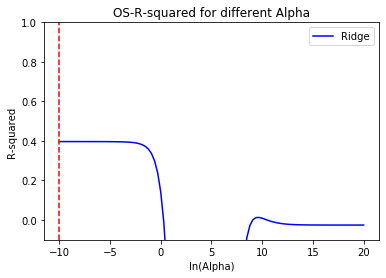

Optimal alpha for Ridge=4.5399929762484854e-05, best OS R_2=0.3968507448253378


In [77]:
# Optimize Ridge
alphas = np.exp(np.linspace(-10,20, num=100))
[alpha_optimal, best_R2, best_coefs] = Regularization_fit_alpha(1,X_train_norm,y_train,X_validation_norm,y_validation,alphas,Graph=True, logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))


In [78]:
ridge_optimal = linear_model.Ridge(alpha=alpha_optimal).fit(X_train_norm, y_train)
print('R_2 on training set:', r2_score(y_train, ridge_optimal.predict(X_train_norm)))
print('R_2 on validation set:', r2_score(y_validation, ridge_optimal.predict(X_validation_norm)))
print('R_2 on test set:', r2_score(y_test, ridge_optimal.predict(X_test_norm)))

R_2 on training set: 0.999999999999729
R_2 on validation set: 0.3968507448253378
R_2 on test set: -0.5279697203930851


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17357853.426789574, tolerance: 14972731.95177306
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21313838.079214554, tolerance: 14972731.95177306
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25953653.67282312, tolerance: 14972731.95177306
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31346189.7

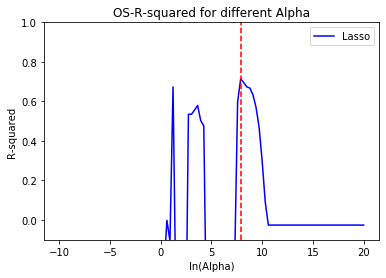

Optimal alpha for Ridge=2640.669807145078, best OS R_2=0.7147505090965012


In [80]:
# Optimize Lasso
alphas = np.exp(np.linspace(-10,20, num=100))
[alpha_optimal, best_R2, best_coefs] = Regularization_fit_alpha(2,X_train_norm,y_train,X_validation_norm,y_validation,alphas,Graph=True, logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [81]:
lasso_optimal = linear_model.Lasso(alpha=alpha_optimal).fit(X_train_norm, y_train)
print('R_2 on training set:', r2_score(y_train, lasso_optimal.predict(X_train_norm)))
print('R_2 on validation set:', r2_score(y_validation, lasso_optimal.predict(X_validation_norm)))
print('R_2 on test set:', r2_score(y_test, lasso_optimal.predict(X_test_norm)))

R_2 on training set: 0.9329719576747086
R_2 on validation set: 0.7147505090965012
R_2 on test set: -0.8334230643553897


In [88]:
#Why do you think performance does not look that good, especially for one of the models?

In [92]:
(ridge_optimal.coef_!=0).sum(), (lasso_optimal.coef_!=0).sum(), X_train_norm.shape[0], X_validation_norm.shape[0], X_test_norm.shape[0]


(159, 23, 74, 43, 58)

In [95]:
np.abs(ridge_optimal.coef_).sum(), np.abs(lasso_optimal.coef_).sum()

(222895.43197036785, 74234.83296729642)

In [96]:
lm_income = linear_model.LinearRegression().fit(X_train_norm, y_train)
lm_income.score(X_train_norm, y_train), lm_income.score(X_validation_norm, y_validation), lm_income.score(X_test_norm, y_test)


(1.0, 0.3906310884977253, -0.5219221607194346)